# Bayesian Networks
EL MANSOURI NADA - CHABACH NADA
This TP provides an excellent opportunity to gain further exposure to relevant topics and applications of Bayesian Networks (diagnosis, prediction, etc.).

Objectives: Students will be able to:
- Create Bayesian Networks.
- Learn Bayesian Networks from real-world problems and datasets.
- Determine inferences from Bayesian Networks.

Technology Requirements:
- Linux (windows user may install virtual machines)
- Python 3.8 or higher (due to pgmpy compatibility)
- Download and install pip and then install pgmpy:
   `$ pip install pgmpy`
- If the previous did not work, this can be done manually after downloading the code source:

```
$ git clone https://github.com/pgmpy/pgmpy
$ cd pgmpy/
$ sudo pip install -r requirements.txt
$ sudo python setup.py install
```


*Note: if you encountered problems installing pip or pgmpy, refer to the pgmpy Installation Page: https://pgmpy.org/started/install.html

In [128]:
!pip install pgmpy

In [129]:
import pgmpy
import pgmpy.models
import pgmpy.inference
import pgmpy.estimators
import pgmpy.inference

import networkx as nx
import matplotlib.pyplot
import xgboost

import pandas as pd
import time

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

## Part 0: Building a model from scratch: Monty Hall Problem

You might know about the famous Monty Hall, or three doors problem (https://en.wikipedia.org/wiki/Monty_Hall_problem). This is a TV game where a contestant $Contestant$ interacts with a host $Host$ to find a price $Price$ hidden behind one of three closed doors. The contestant makes a first choice of one door they would like to open. The host will then help the contestant by opening one of the doors, leaving the contestant to choose again amongst 2 doors. If the chosen door hides the price, the constestant wins.

The host rules for choosing a door to open are:
 - never open the door behind which the price is hidden
 - never open the door chosen by the contestant

A mathematician states: "Selecting in the second step the door that wasn't chosen in the first step, has a 66% probability of granting the price to the contestant". We want to use Bayesian Network modeling to affirm or infirm this statement.

We will model this problem with a three states Bayesian Network.
 - $Contestant$ is a random variable with 3 possible values (the first chosen door by the contestant)
 - $Price$ is a random variable with 3 possible values (the price door)
 - $Host$ is a random variable with 3 possible values (the opened door by the host)

The price is placed before the contestant make its first choice, and the contestant has no indication on its location.


**Question**: From your understanding of the statement, write the independence and conditional independence relations you expect about $Contestant, Price, Host$, in the form "X indep Y" or "X indep Y | Z". (*A relation "X indep Y" means that X and Y value are set independently, without any link or interaction. A relation "X indep Y | Z" means that X and Y have been chosen with respect to a same information which is the value of Z, but other than that, there is no further link between the value of X and Y.*)

Contestant indep Price

Contestant indep Price ∣ Host: Even after the host has opened a door, the contestant still has no information about the location of the price.


**TODO 0.1** Instantiate an object you will name `monty_hall`, from the class `pgmpy.models.BayesianNetwork` (https://pgmpy.org/models/bayesiannetwork.html). Add edges with its `.add_edge` method, corresponding to each edge in the Monty Hall graph.

Run the cell after to visualize the network.

In [130]:
# TODO
from pgmpy.models import BayesianNetwork
monty_hall = BayesianNetwork()
monty_hall.add_edges_from([('Price', 'Host'), ('Contestant','Host')])

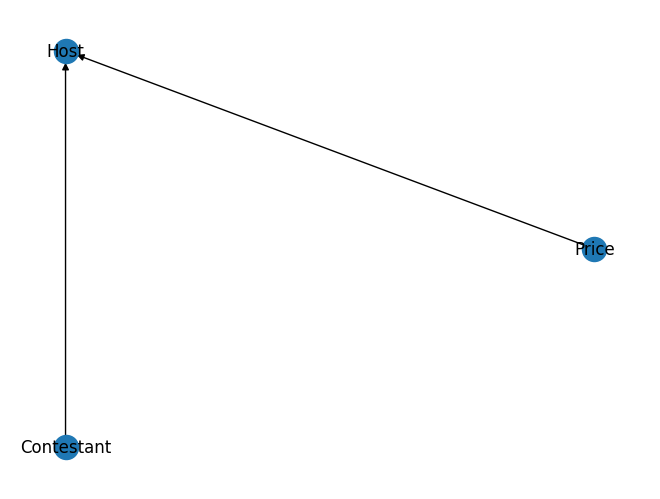

In [131]:
# RUN THIS CELL

def plot_bayesian_network(bn):

    # Convert to a directed graph for visualization
    G = nx.DiGraph(bn.edges())

    # Draw the graph
    nx.draw(G, with_labels=True, pos=nx.circular_layout(G))

plot_bayesian_network(monty_hall)

**TODO 0.2**: BayesianNetwork objects have a method that allows to find automatically the independence relations: `.get_independencies` (https://pgmpy.org/base/base.html). Verify that the relations encoded in the network match your answer to the first question.

If the relations differ, try to explain your reasoning (no point will be deducted for an explained incorrect answer).

In [132]:
# TODO
independencies = monty_hall.get_independencies()
print(independencies)

(Contestant ⟂ Price)
(Price ⟂ Contestant)


Yes, it matches the expectations from the first response. We predicted that Contestant would be independent of Price when the contestant makes their initial choice. The contestant has no information about the price location, so these two variables are not linked.
the model correctly captures this independence,if the relations involving Host do not appear at this stage, it may be because the conditional probabilities have not yet been added, which would refine the network’s structure.

Since we have specified the structure of the bayesian network in `monty_hall`, we must now provide the conditional probability distribution.

We assume that both $Contestant$ and $Price$ are chosen randomly (with probability uniformly $\frac13$).

**TODO 0.3** Use `pgmpy.factors.discrete.CPD.TabularCPD` (https://pgmpy.org/factors/discrete.html) to specify the conditional probability distribution of $Contestant$ and of $Price$. Name the TabularCPD of "Contestant" as `cpd_c` and "Price" as `cpd_p`.

Hint: a coin toss can be modeled by `TabularCPD("coin_toss", 2, [[0.5], [0.5]])`

The name of each variable (in first argument) must be identical to the corresponding node in the BayesianNetwork graph `montly_hall`.

In [133]:
# TODO

cpd_c = pgmpy.factors.discrete.CPD.TabularCPD(variable='Contestant', variable_card=3, values=[[1/3], [1/3], [1/3]])
cpd_p = pgmpy.factors.discrete.CPD.TabularCPD(variable='Price', variable_card=3, values=[[1/3], [1/3], [1/3]])



Run the following cell.

In [134]:
# RUN THIS CELL

cpd_h = pgmpy.factors.discrete.CPD.TabularCPD("Host",3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],  #Host=0
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],  #Host=1
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],  #Host=2
    ],
    evidence=["Contestant", "Price"],
    evidence_card=[3, 3])

cpd_h._truncate_strtable = lambda x: x  # prevents table truncating
print(cpd_h)

+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Contestant | Contestant(0) | Contestant(0) | Contestant(0) | Contestant(1) | Contestant(1) | Contestant(1) | Contestant(2) | Contestant(2) | Contestant(2) |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Price      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Host(0)    | 0.0           | 0.0           | 0.0           | 0.0           | 0.5           | 1.0           | 0.0           | 1.0           | 0.5           |
+------------+---------------+---------------+

**Question**: From the table, what is the value of $\mathbb{P}(Host=0 | Contestant=1, Price=2)$? How do you interpret this value with respect to the problem setting?

**Question**: How many numerical parameters in total were created to build this Bayesian Network? How many would be needed to create the entire joint probability table of $\mathbb{P}(Contestant, Price, Host)$?

**Answer1:**
From the table, the value of
P(Host=0|Contestant=1,Price=2)=1, In this scenario, the contestant has chosen door 1, and the prize is behind door 2. SO the host  cannot open door 1  or door 2. Therefore, the host must open door 0, and the probability of this happening is 1 (his only choice).

**Answer2: **
 the total number of parameters for Host is
9×2=18,the Host depends on both Contestant and Price: There are 3 parameters for the probabilities associated with each door that the contestant can choose + there are 3 parameters for the Price variable + (For each combination there are 2 parameters =18) = **24** parameters.
For the full joint probability table of
P(Contestant,Price,Host), there would be
3x3x3=27 possible combinations of these three variables.
and since the sum of all probabilities must equal 1, you would only need 27-1=26 parameters to fully specify the joint probability table.


Run the following cell to add the probability tables to the `monty_hall` object.

In [136]:
# RUN THIS CELL

# We now add the conditional probability distributions (cpd) to the bayesian network.

monty_hall.add_cpds(cpd_c, cpd_p, cpd_h)

# Verify that the model is correctly specified

assert monty_hall.check_model()

If the previous cell throws an error, you may have mispecified either the monty_hall graph (todo 0.1) or the CPD of $Contestant$ and $Price$ (todo 0.3).

You can check how `check_model` verifies the BayesianNetwork in its documentation (https://pgmpy.org/models/bayesiannetwork.html)

### Application

Suppose that you, as a contestant, have chosen $Contestant=0$ as your first guess.

The host might open door $Host=1$, or $Host=2$ as a result (but never door $0$ as it was chosen by the contestant).

**TODO 0.4** Using `pgmpy.inference.ExactInference.VariableElimination` (https://pgmpy.org/exact_infer/ve.html), compute the exact conditional probability distribution of $\mathbb{P}(Price|Contestant=0,Host=1)$ and $\mathbb{P}(Price|Contestant=0,Host=2)$.

Once a VariableElimination object has been set, you can use the class method `VariableElimination.query` with adequate `variables` and `evidence` parameters. The remaining arguments can be set to their default values.

In [137]:
inference = pgmpy.inference.ExactInference.VariableElimination(monty_hall)

# TODO
prob_price1 = inference.query(variables=['Price'], evidence={'Contestant': 0, 'Host': 1})

# plot the result
print(prob_price1)


+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.0000 |
+----------+--------------+
| Price(2) |       0.6667 |
+----------+--------------+


In [138]:
prob_price2 = inference.query(variables=['Price'], evidence={'Contestant': 0, 'Host': 2})

print(prob_price2)


+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.6667 |
+----------+--------------+
| Price(2) |       0.0000 |
+----------+--------------+


**Question**: According to the two result tables, should you maintain your choice of door, or select the remaining door?
i will change my choice, because there’s a higher probability that the prize is behind the door not initially chosen.

**Question**: Even though the contestant final choice has one of two doors, why are the probability of success not (0.5, 0.5)?
When the contestant first picks a door, there is a 1/3 chance the prize is behind the chosen door, and a 2/3 chance it's behind one of the other two doors. The host knows where the prize is and will always open a door that doesn’t have the prize, which influences the probabilities.


## Part 1: Bayesian Modeling of a credit risk dataset

This part is dedicated to learning a Bayesian model (graph and distribution) to model Credit risk in Germany. In this part, we will not specify the structure by hand, instead it will be learned from the data.

We will see how to:
 - open and inspect a dataset as a DataFrame
 - handle missing values with and without domain knowledge
 - apply binning to variables with lots of possible values with and without domain knowledge
 - separate data into training and validation sets

First, run the following cell to open the data in the form of a `pandas.DataFrame`.

In [139]:
german_credit = pd.read_csv("https://raw.githubusercontent.com/vidhi-chugh/tds_articles/master/pgmpy_WICDS/german_credit.csv")
german_credit

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,NaN,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,31,female,1,own,little,1736,12,furniture/equipment,good
996,2,40,male,3,own,little,3857,30,car,good
997,2,38,male,2,own,little,804,12,radio/TV,good
998,2,23,male,2,free,little,1845,45,radio/TV,bad


**Question**: What do rows represent? What do columns represent?
Rows: each row represents a credit case for a customer
Columns: each column represents a feature about the customer or credit, such as credit history, age, job, housing, and risk.



**Question**: What is the name (in the data) of the variable that we want to model?
The variable we want to model is Risk (good or bad).

**Question**: Are there categorical variables? Continuous? Discrete?
Categorical: gender, housing, saving accounts, purpose,risk
Continuous: age, credit amount, duration.
Discrete: credit History, job.

### Data Preparation

Before we can use the dataset to model credit risk, we must prepare the data to ensure that it can be used properly. This generally involves three steps.
 - Ensuring that there are no missing values
 - Ensuring that all columns have a type that allows Bayesian Network structure learning and estimation. Specifically, all variables should be discrete, with a sufficiently low number of possible values (https://pgmpy.org/index.html).
 - Separing the data into training and validation sets. The training set is used for structure learning and parameter estimation. The validation set is used to compare different learned models on a prediction task.


We will first handle missing (NaN) values.
- A domain expert tells us that missing values in `"Saving accounts"` are valid. A NaN values show that the credit seeker does not have a saving account. We will replace this value by `"no account"`.

In [140]:
# RUN THIS CELL

# in this cell, german_credit['Saving accounts'].isnull() provides the index table of all null saving account rows.
# then, german_credit.loc[... ,'Saving accounts'] select the cells to be set to the value "no account"

german_credit.loc[german_credit['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

**TODO 1.1**: Is there any other column with missing values? You can use the `DataFrame.isnull()` method to check if a value is null, and the `DataFrame.sum(axis=0)` method to get the number of nonzero values in each column.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html)
(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html)

If there is any missing value remaining, remove the corresponding rows from the DataFrame, using the `.dropna()` method.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)

In [141]:
# TODO
missing_values = german_credit.isnull().sum(axis=0)
print(missing_values)

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64


Now that we have dealt with missing values, we must ensure that variables are discrete with low number of possible values.
We will arbitrarily say that **above 10 values** is too many.

When a variable has too many values, we must apply binning to it. Binning means grouping together values under new names, into a small number of categories. There are different strategy to binning.
 - A domain expert might create meaningful binning from prior knowledge. For instance, age is usually grouped in 18-25, 26-45, 46-65, 65+ categories.
 - When no prior knowledge is available, a common strategy on ordered data (where a "lesser than" notion makes sense) is to create bins of equal population with ordered values. For instance, age could be grouped in three groups from 18 to 30, 31 to 37, 37+ if each group correspond to roughly the same number of observations (rows).

The following cell iterates over the columns of the dataset, and for each of them, prints the number of unique values contained in the column. It uses `pd.DataFrame.columns` (https://pandas.pydata.org/docs/reference/frame.html) and `pd.Series.unique` (https://pandas.pydata.org/docs/reference/series.html).

In [142]:
# RUN THIS CELL
for variable in german_credit.columns:
    print("Variable '{}' has {} possible values".format(variable, len(german_credit[variable].unique())))

Variable 'Credit History' has 5 possible values
Variable 'Age' has 53 possible values
Variable 'Gender' has 2 possible values
Variable 'Job' has 4 possible values
Variable 'Housing' has 3 possible values
Variable 'Saving accounts' has 5 possible values
Variable 'Credit amount' has 921 possible values
Variable 'Duration' has 33 possible values
Variable 'Purpose' has 8 possible values
Variable 'Risk' has 2 possible values


**Question** Which columns seem to have too many unique values to handle like categorical variables?

the following columns have too many unique values:
Age, Credit amount, Duration.
These columns have more than 10 unique values and need to be binned to reduce the number of categories.

**TODO 1.2**: Apply the function `pandas.qcut` (https://pandas.pydata.org/docs/reference/api/pandas.qcut.html), with quantiles `q=[0, .33, .66, 1]` to make three equally populated bins, for `Age`,`Credit amount`, and `Duration`.

You should replace the previous column with the new value: syntax `dataframe[column] = pd.qcut(...)`.

In [143]:
# TODO
german_credit['Age'] = pd.qcut(german_credit['Age'], q=[0, .33, .66, 1], labels=['young', 'middle-aged', 'senior'])
german_credit['Credit amount'] = pd.qcut(german_credit['Credit amount'], q=[0, .33, .66, 1], labels=['low', 'medium', 'high'])
german_credit['Duration'] = pd.qcut(german_credit['Duration'], q=[0, .33, .66, 1], labels=['short-term', 'mid-term', 'long-term'])

In [144]:
# RUN THIS CELL
# verify that Age, Credit amount and Duration have been correctly prepared
for variable in ["Age", "Credit amount", "Duration"]:
    assert len(german_credit[variable].unique())==3
    print("Variable '{}' has the following list of possible values: {}".format(variable, german_credit[variable].unique()))

Variable 'Age' has the following list of possible values: ['senior', 'young', 'middle-aged']
Categories (3, object): ['young' < 'middle-aged' < 'senior']
Variable 'Credit amount' has the following list of possible values: ['low', 'high', 'medium']
Categories (3, object): ['low' < 'medium' < 'high']
Variable 'Duration' has the following list of possible values: ['short-term', 'long-term', 'mid-term']
Categories (3, object): ['short-term' < 'mid-term' < 'long-term']


**TODO 1.3**: To separate our Train/Validation sets, use the method `DataFrame.sample` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to sample without replacement a fraction 0.9 of the dataset german_credit, called `train_set`. Use the method `DataFrame.drop` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) with indexes `train_set.index` to create a validation set `val_set`. **IMPORTANT** for reproducibility, make sure to seed your sample selection with parameter `random_state`.

In [145]:
# TODO
# the training set
train_set = german_credit.sample(frac=0.9, random_state=42)
# Create the validation set
val_set = german_credit.drop(train_set.index)


In [146]:
# RUN THIS CELL

assert len(train_set)==900
assert len(val_set)==100

We will put aside the validation set for the remainder of part 1 and part 2.

### Model learning

To learn a Bayesian Network structure fitting the data, `pgmpy` provides several algorithms. We will use Hill Climb Search (https://pgmpy.org/structure_estimator/hill.html).
This algorithm:
 - is greedy: a scoring function is optimized by making gradual modification to a Directed Acyclic Graph, until no modification can improve the score (hence, hill-climbing).
 - is heuristic: the scoring function represents some sort of belief of what a best network structure would be. For instance, a best graph would both fit the data well while having a small *description length* (an encoding of this graph should be as small as possible) (BIC score, AIC score). Another best graph concept would rely on fitting the data well while maximizing a probability over a distribution of graphs (K2 score, DBE score...). See http://www.lx.it.pt/~asmc/pub/talks/09-TA/ta_pres.pdf for more details.

**TODO 1.4**: Instanciate `pgmpy.estimators.HillClimbSearch` on the training set. Apply the method `HillClimbSearch.estimate` on the instance, with `k2score`, and otherwise default parameters. Finally, reuse `plot_bayesian_network` defined in part 0 to plot the learned network.


  0%|          | 0/1000000 [00:00<?, ?it/s]

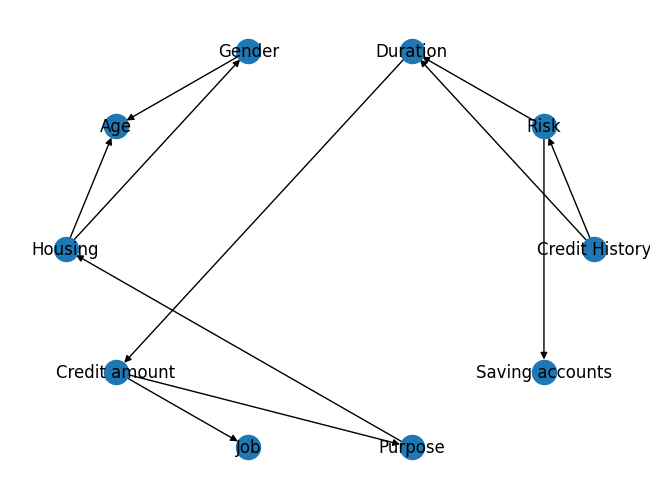

In [147]:
# TODO
from pgmpy.estimators import HillClimbSearch, K2Score
# Instanciate Hill Climb Search
hcs = HillClimbSearch(train_set)

# K2 score
k2score = K2Score(train_set)

model_k2 = hcs.estimate(scoring_method=k2score)

# Visualise the network
plot_bayesian_network(model_k2)


**TODO 1.5**: The `estimate` method argument `tabu_length` controls how many of the last graph modifications are impossible to modify. Run another graph estimation while setting `tabu_length=1`. Is there any change to the graph?

  0%|          | 0/1000000 [00:00<?, ?it/s]

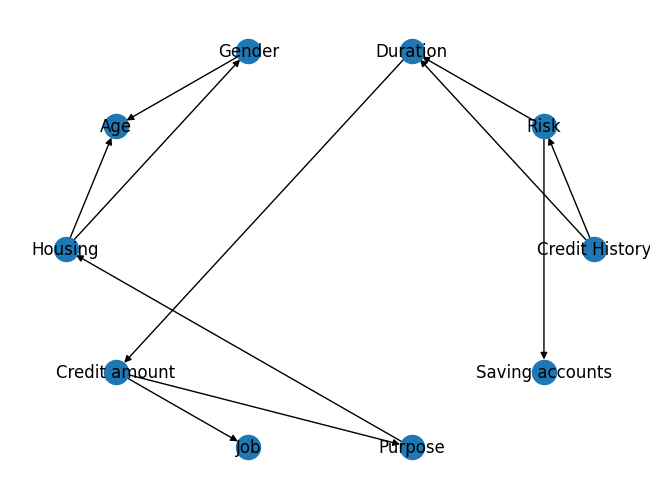

In [148]:
# TODO
model_tabu = hcs.estimate(scoring_method=k2score, tabu_length=1)
plot_bayesian_network(model_tabu)

**TODO 1.6**: As mentionned before, different scoring functions encode different beliefs of what an optimal graph would look like. Apply the `estimate` method with `bicscore` scoring method. The BIC (Bayesian Information Criterion) penalizes graphs with a lot of edges, under the belief that the simplest structure is the most likely (Occam's razor https://en.wikipedia.org/wiki/Occam%27s_razor).

  0%|          | 0/1000000 [00:00<?, ?it/s]

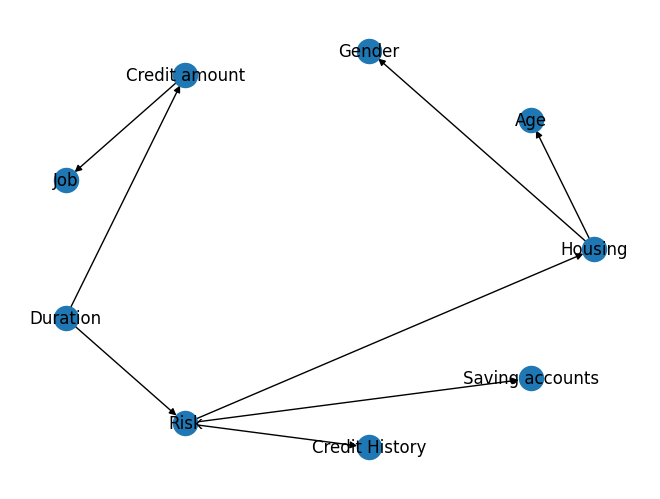

In [149]:
## TODO
from pgmpy.estimators import BicScore

bic_score = BicScore(train_set)
model_bic = hcs.estimate(scoring_method=bic_score)
plot_bayesian_network(model_bic)

**Question** To your opinion, which graph is simpler to interpret?
In our opinion, the graph generated using the BIC score is simpler to interpret. It has little connections between the variables, what make it easier to understand.

**Question** To your opinion, which graph is faster to evaluate?
The graph using the BIC score is also  faster to evaluate because it has fewer edges.


We will now use the graph produced by the `bicscore` method. We now need to learn a set of factor functions to model the joint probability distribution.
Precisely, for each node $V$ with parents (in-going edges) $Pa(V)$, we learn $\mathbb{P}(V|Pa(V))$.

The library pgmpy provides several parameter estimation algorithms, each with different particularities. The one we will use is the following:
 - Maximum Likelihood Estimation (https://pgmpy.org/param_estimator/mle.html): estimates joint probabilities by using the frequency/count of each configuration of values. It needs all variables to be observed in the data.

There are other methods, that do not apply to our case:
 - Expectation Maximization (https://pgmpy.org/param_estimator/em.html): Used in the presence of *latent* variables, i.e. variables in the graph for which there is no data. Expectation Maximization does not maximize the likelihood of the joint distribution, but the expectation of this likelihood.
 - Bayesian Estimation (https://pgmpy.org/param_estimator/bayesian_est.html): Used when domain knowledge, or belief, is known beside what is recorded in the data. This knowledge is specified to the algorithm in the form of *priors*. Due to the additional information, parameter estimates typically require less observations than Maximum Likelihood Estimation.




**TODO 1.7**: Apply MLE (https://pgmpy.org/param_estimator/mle.html) with its `.get_parameters()` method to estimate the parameters of the Bayesian Network. Add the parameters to a model object (class `pgmpy.models.BayesianNetwork`) built from the graph structure obtained with bicscore. You will name this model `model`. Use the training data only.

In [150]:
# TODO
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianNetwork(model_bic.edges())
# Apply MLE
model.fit(train_set, estimator=MaximumLikelihoodEstimator)

# plot the parametes(the cpds)
parameters = model.get_cpds()
for param in parameters:
    print(param)

+---------------+---------------------+---------------------+
| Risk          | Risk(bad)           | Risk(good)          |
+---------------+---------------------+---------------------+
| Housing(free) | 0.15471698113207547 | 0.09291338582677165 |
+---------------+---------------------+---------------------+
| Housing(own)  | 0.6075471698113207  | 0.7543307086614173  |
+---------------+---------------------+---------------------+
| Housing(rent) | 0.23773584905660378 | 0.15275590551181104 |
+---------------+---------------------+---------------------+
+------------------+---------------+--------------+---------------+
| Housing          | Housing(free) | Housing(own) | Housing(rent) |
+------------------+---------------+--------------+---------------+
| Age(middle-aged) | 0.34          | 0.384375     | 0.21875       |
+------------------+---------------+--------------+---------------+
| Age(senior)      | 0.58          | 0.315625     | 0.18125       |
+------------------+--------------

In [151]:
# RUN THIS CELL
assert model.check_model()

## Part 2: Bayesian Inference

In this part, we will use the previous model to analyse the mechanisms behind Credit Risk attribution by banks.

We will first examine relations between `Gender` and `Risk`.

**TODO 2.1**: Use Variable Elimination to print the joint distribution $\mathbb{P}$(`Gender`,`Risk`). Use Variable Elimination to print the conditional distribution $\mathbb{P}$(`Risk`|`Gender`) for both Gender values.

In [152]:
# TODO
from pgmpy.inference import VariableElimination

# Create an inference object
inference = VariableElimination(model)

# Calculate P(Gender, Risk)
joint_distribution = inference.query(variables=['Gender', 'Risk'])
print(joint_distribution)

# Calculate  P(Risk | Gender=female)
conditional_distribution_female = inference.query(variables=['Risk'], evidence={'Gender': 'female'})
print(conditional_distribution_female)

# Calculate P(Risk | Gender=male)
conditional_distribution_male = inference.query(variables=['Risk'], evidence={'Gender': 'male'})
print(conditional_distribution_male)

+----------------+------------+--------------------+
| Gender         | Risk       |   phi(Gender,Risk) |
+================+============+====================+
| Gender(female) | Risk(bad)  |             0.0917 |
+----------------+------------+--------------------+
| Gender(female) | Risk(good) |             0.2083 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(bad)  |             0.2027 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(good) |             0.4973 |
+----------------+------------+--------------------+
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3058 |
+------------+-------------+
| Risk(good) |      0.6942 |
+------------+-------------+
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2896 |
+------------+-------------+
| Risk(good) |      0.7104 |
+------------+-------------+


**Question**: Are gender differences associated to lowered risk? What is hidden in the conditional distribution, that is apparent in the joint distribution? What prior would be needed to deduce the joint distribution $\mathbb{P}$(`Gender`,`Risk`) from the conditional distributions $\mathbb{P}$(`Risk`|`Gender`)?

The conditional distribution shows that there
is no significant difference between men and women when it comes to credit risk,the men have a higher probability of having a good credit risk compared to women, but the differences are not extreme.
The conditional distribution only shows P(Risk | Gender), which tells us how risk is distributed given the gender, but it hides the overall proportion of men and women in the dataset.
To deduce the joint distribution P(Gender, Risk) from the conditional distributions P(Risk | Gender), we think we need to know the prior probabilities P(Gender=female) and P(Gender=male) in the dataset.



**TODO 2.2**: Examine how some of the other variables are associated to varying Risk (using conditional distributions). Write down your conclusions.

In [153]:
# TODO
# Joint distribution P(Job, Risk)
joint_distribution = inference.query(variables=['Job', 'Risk'])
print("\nJoint distribution P(Job, Risk):")
print(joint_distribution)
# Conditional distribution P(Risk | Job)
print("\nConditional distribution P(Risk | Job):")
job_risk_distribution = inference.query(variables=['Risk'], evidence={'Job': 0})  # unskilled
print(job_risk_distribution)
job_risk_distribution_1 = inference.query(variables=['Risk'], evidence={'Job': 1})  # semi-skilled
print(job_risk_distribution_1)
job_risk_distribution_2 = inference.query(variables=['Risk'], evidence={'Job': 2})  # skilled
print(job_risk_distribution_2)
job_risk_distribution_3 = inference.query(variables=['Risk'], evidence={'Job': 3})  # highly skilled
print(job_risk_distribution_3)



Joint distribution P(Job, Risk):
+--------+------------+-----------------+
| Job    | Risk       |   phi(Job,Risk) |
+========+============+=================+
| Job(0) | Risk(bad)  |          0.0068 |
+--------+------------+-----------------+
| Job(0) | Risk(good) |          0.0176 |
+--------+------------+-----------------+
| Job(1) | Risk(bad)  |          0.0574 |
+--------+------------+-----------------+
| Job(1) | Risk(good) |          0.1481 |
+--------+------------+-----------------+
| Job(2) | Risk(bad)  |          0.1842 |
+--------+------------+-----------------+
| Job(2) | Risk(good) |          0.4425 |
+--------+------------+-----------------+
| Job(3) | Risk(bad)  |          0.0460 |
+--------+------------+-----------------+
| Job(3) | Risk(good) |          0.0973 |
+--------+------------+-----------------+

Conditional distribution P(Risk | Job):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2789 |
+----------

In [154]:
# Joint distribution P(Housing, Risk)
joint_distribution_housing = inference.query(variables=['Housing', 'Risk'])
print("\nJoint distribution P(Housing, Risk):")
print(joint_distribution_housing)

# Conditional distribution P(Risk | Housing)
print("\nConditional distribution P(Risk | Housing):")
housing_risk_distribution_own = inference.query(variables=['Risk'], evidence={'Housing': 'own'})  # Owns the house
print(housing_risk_distribution_own)

housing_risk_distribution_rent = inference.query(variables=['Risk'], evidence={'Housing': 'rent'})  # Rents the house
print(housing_risk_distribution_rent)

housing_risk_distribution_free = inference.query(variables=['Risk'], evidence={'Housing': 'free'})  # Free housing
print(housing_risk_distribution_free)



Joint distribution P(Housing, Risk):
+---------------+------------+---------------------+
| Housing       | Risk       |   phi(Housing,Risk) |
+===============+============+=====================+
| Housing(free) | Risk(bad)  |              0.0456 |
+---------------+------------+---------------------+
| Housing(free) | Risk(good) |              0.0656 |
+---------------+------------+---------------------+
| Housing(own)  | Risk(bad)  |              0.1789 |
+---------------+------------+---------------------+
| Housing(own)  | Risk(good) |              0.5322 |
+---------------+------------+---------------------+
| Housing(rent) | Risk(bad)  |              0.0700 |
+---------------+------------+---------------------+
| Housing(rent) | Risk(good) |              0.1078 |
+---------------+------------+---------------------+

Conditional distribution P(Risk | Housing):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2516 |
+-----

From the joint and conditional distributions, we see the higher-skilled jobs have a  higher probability of good credit risk compared to unskilled workers. The conditional distribution shows a clear trend: as job skill level increases, the likelihood of bad credit risk decreases. For Job 0 the probability of bad risk is higher, whereas for highly skilled, the bad credit risk is very low, reinforcing the idea that higher job skill levels are associated with lower credit risk.

**BONUS Question** Job categories go from "0 - unskilled" to "3 - highly skilled". Does the risk evolution in function of the Job attribute correspond to your expectations? If not, what could be the reason for the difference?
Yes, the risk evolution based on the Job attribute corresponds to my expectations. The data shows that unskilled workers have a higher risk of bad credit, while highly skilled workers have a lower risk of bad credit.This aligns with the idea that higher-skilled workers usually have more stable jobs, so the better financial management and lower credit risk.

The Bayesian Network associated to german credit has 9 variables. The previous joint and conditional distribution only involve 2 of them. Therefore, the algorithm has eliminated 7 variables.

The computation time of the inference might change depending on the order in which variables are eliminated. The elimination order is controlled by the parameter `elimination_order` of the `.query` method.

**TODO 2.3** For an identical query of joint probability $\mathbb{P}(Risk, .)$ between the Risk and an arbitrary variable, measure the time spent when given different elimination orders (`greedy`, `MinFill`, `MinNeighbors`, `MinWeight`). You may use `time.time()` to obtain the current time.

In [155]:
# TODO
import time
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)
elimination_orders = ['greedy', 'MinFill', 'MinNeighbors', 'MinWeight']
execution_times = {}

# loop to test the time for each elimination order
for order in elimination_orders:
    start_time = time.time()  # depart time
    result = inference.query(variables=['Risk'], elimination_order=order)
    end_time = time.time()  # Temps de fin
    execution_times[order] = end_time - start_time  # Calculet the total time

# print the results
for order, exec_time in execution_times.items():
    print(f"Elimination order: {order}, duration: {exec_time:.6f} seconds")


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Elimination order: greedy, duration: 0.001166 seconds
Elimination order: MinFill, duration: 0.051500 seconds
Elimination order: MinNeighbors, duration: 0.064237 seconds
Elimination order: MinWeight, duration: 0.053491 seconds


The Bayesian Network can help us with *Feature Selection*. The goal of feature selection is to select a subset of variables that contain all the necessary information about `Risk`, i.e., the *Markov Blanket*.

For instance, variable `Job` might have information on `Risk` (i.e., not independent), but this information might already be contained in another variable, making `Job` redundant.

**TODO 2.4** To know which variables can be made independent from `Risk` by conditioning on other variables, it is possible to use the graph structure. Find a Markov Blanket of `Risk`. The method `BayesianNetwork.get_markov_blanket` (https://pgmpy.org/base/base.html) is ready made for this task.

In [156]:
## TODO
markov_blanket_risk =model.get_markov_blanket('Risk')
print("Markov Blanket of Risk:", markov_blanket_risk)


Markov Blanket of Risk: ['Housing', 'Credit History', 'Saving accounts', 'Duration']


**Question** Interpret the markov blanket information: what is a markov blanket and what does it mean regarding how banks attribute credit risk rating?

The Markov Blanket for Risk includes Housing, Credit History, Saving accounts, and Duration, meaning these are the key factors that directly affect or are affected by a person’s credit risk(dependency). For banks, this suggests that when evaluating someone’s credit risk, these variables hold the most important information. Essentially, focusing on these four factors gives banks all they need to make a solid decision about a person’s creditworthiness, without needing to look at other variables. This makes the credit risk assessment more efficient and focused.

#### BONUS: causal inference

**This bonus part covers an application of Bayesian Network not covered during the CM. You may go to part 3 directly then come back to it later.**

We will now consider the variable `Job`, for which we observe that Risk is different depending on the category. We can say clearly that Job and Risk aren't **independent**. What we cannot say while looking uniquely at the conditional probability distribution, is whether `Job` influences (is a cause of) `Risk`. Indeed, variables can be associated but not causated.

It is generally difficult to determine causal relationships from observed data. Assuming that causal effects are *linear* (meaning that if `Job` has an influence on `Risk`, then this influence can be correctly modeled by a linear regression model), the causal inference framework (https://pgmpy.org/exact_infer/causal.html) allows to estimate whether two associated variables have a causal influence on each other (Average Treatement Effect https://en.wikipedia.org/wiki/Average_treatment_effect). The question it solves is the following: "if a credit seeker's job category were to increase due to a job change, how much would Risk increase?"

Precisely, the ATE is the difference between the expected Risk when the job stays the same, compared to the expected Risk when the job category increases.

**TODO 2.6**: Apply `pgmpy.inference.CausalInference` with its method `.estimate_ate` on training data, to infer if `Job` has an influence on `Risk`.

In [157]:
#TODO
from pgmpy.inference import CausalInference

causal_inference = CausalInference(model)

# Apply estimate_ate
ate = causal_inference.estimate_ate( X='Job', Y='Risk', data=train_set)

print(f"Estimated ATE of Job on Risk: {ate}")


Estimated ATE of Job on Risk: 0.0


**Question**: Is Job category causaly linked to Risk?

Based on  the ATE, it suggests that Job category is not causally linked to Risk. This means that, changes in the job category do not directly influence or cause changes in the credit risk score.

We now consider the variable `Duration`. We can confirm that it is associated to `Risk`, with higher credit amount related to greater proportion of 'bad' risk. Again, we would like to know if this is a cause-effect relation.

We will now use another way of quantifying causal relationships: *do-calculus* with *counterfactuals*. The question it solves is: "if all credit seekers were to be attributed the same duration by the bank, how would risk be distributed?" If Duration and Risk are not causaly linked, then the resulting distribution of Risk will be identical for all durations.

**TODO 2.7**: Use `CausalInference.query` to estimate the Risk after a do operation on Duration for each category of duration (specify `do={"Duration":value}` for appropriate values).


In [161]:
#TODO

causal_inference = CausalInference(model)

#  Estimate the Risk after a do operation on Duration for each category
ate_duration_1 = causal_inference.query(variables=['Risk'], do={'Duration': 'short-term'})
ate_duration_2 = causal_inference.query(variables=['Risk'], do={'Duration': 'mid-term'})
ate_duration_3 = causal_inference.query(variables=['Risk'], do={'Duration': 'long-term'})

# plot the results
print("ATE for Duration 1:", ate_duration_1)
print("ATE for Duration 2:", ate_duration_2)
print("ATE for Duration 3:", ate_duration_3)



ATE for Duration 1: +------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2081 |
+------------+-------------+
| Risk(good) |      0.7919 |
+------------+-------------+
ATE for Duration 2: +------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2916 |
+------------+-------------+
| Risk(good) |      0.7084 |
+------------+-------------+
ATE for Duration 3: +------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4313 |
+------------+-------------+
| Risk(good) |      0.5687 |
+------------+-------------+


**Question**: Is Duration causaly linked to Risk?

## Part 3: Bayesian models as predictive models

Now that we have learned a model of the training data, we can apply it to validation data to evaluate how it works as a predictive model. We can use Maximum A Posteriori inference, to find out what Risk is most likely considering the values of the other variables. Formally, for a given validation sample $s$ where Risk is removed, we want to estimate $\arg \max \mathbb{P}(Risk | Gender,...,Housing=s)$.

**TODO 3.1**: Use `VariableElimination.map_query` (https://pgmpy.org/exact_infer/ve.html) to predict and store credit risk for each sample in the validation set. You can iterate over samples by using `val_set.to_dict()`, each row being converted to a dictionary. Make sure to not include `Risk` in the evidences.

You will need to store the true risk in a list `y_true` for each sample, and store the corresponding predicted value into a list `y_pred`.

In [102]:
#TODO
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)

y_true = []
y_pred = []

# Iterate over each sample in the validation set
for index, sample in val_set.iterrows():
    evidence = dict(sample)
    true_risk = evidence.pop('Risk')
    y_true.append(true_risk)

    # Filter evidence
    filtered_evidence = {var: value for var, value in evidence.items() if var in model.nodes()}

    # Predict the risk with map_query
    predicted_risk = inference.map_query(variables=['Risk'], evidence=filtered_evidence)['Risk']

    # Ajouter la prédiction à y_pred
    y_pred.append(predicted_risk)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Run the next cell to visualize the classification performance.

Classification accuracy: 0.68


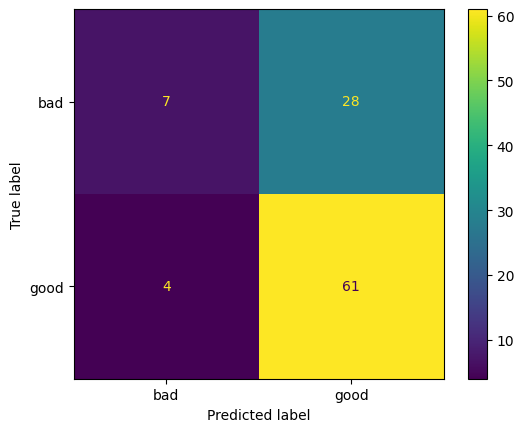

In [99]:
# RUN THIS CELL

print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**Question** The previous snipet plots a Confusion Matrix. Briefly explain what it means.
The rows represent the true labels,and the columns represent the predicted labels,it used to evaluate the performance of a classification model by comparing the predicted values to the real values.

**Question** What is the link between the confusion matrix and the accuracy metric?
Accuracy is a metric that indicates the overall correctness of the model:Accuracy= (True positives+True negatives)/Total Instances = 61+7/100 = 0.68


**Question** What would be False Positive and False Negative in this confusion matrix? Which one would you rather minimize if you were to work for a bank?

False positive: the model predicted low risk but the actual label was high risk.,in this matrix, there are 28 False Positives.
False Negative: the model predicted high risk but the actual label was low risk,there are 4 False Negatives.
If we work for a bank, it would be more important to minimize False Negatives because incorrectly classifying a "good" customer as "bad" means rejecting someone who would be a good customer.

We would like to compare the previous map_query predictive model to a standard machine learning model.

We will use XGBoost, one of the main libraries of simple learning models based on "boosting" and specifically "gradient boosting" (https://xgboost.readthedocs.io/en/stable/).


XGBoost is a library that can only manipulate numerical values. Columns "Gender", "Housing", "Saving accounts", "Purpose", and "Risk" contain strings, so we need to transform them. For each of these columns, the next cell creates a new column with suffix "_numerical" (i.e. "Gender_numerical"), where each of the string values is replaced by an integer. This can be done with `.apply`
(https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) and a function, or `.map` (https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) and a dictionary.


In [100]:
# Run this cell.

#method 1
label_mapping = {'good': 0, 'bad': 1}
val_set['Risk_numerical'] = val_set['Risk'].map(label_mapping)
train_set['Risk_numerical'] = train_set['Risk'].map(label_mapping)

#method 2
label_mapping = dict([(value,index) for index,value in enumerate(german_credit["Gender"].unique())])
val_set['Gender_numerical'] = val_set['Gender'].map(label_mapping)
train_set['Gender_numerical'] = train_set['Gender'].map(label_mapping)

#method 3
label_mapping = lambda x: german_credit["Housing"].unique().tolist().index(x)
val_set['Housing_numerical'] = val_set['Housing'].apply(label_mapping)
train_set['Housing_numerical'] = train_set['Housing'].apply(label_mapping)

label_mapping = lambda x: german_credit["Saving accounts"].unique().tolist().index(x)
val_set['Saving accounts_numerical'] = val_set['Saving accounts'].apply(label_mapping)
train_set['Saving accounts_numerical'] = train_set['Saving accounts'].apply(label_mapping)

label_mapping = lambda x: german_credit["Purpose"].unique().tolist().index(x)
val_set['Purpose_numerical'] = val_set['Purpose'].apply(label_mapping)
train_set['Purpose_numerical'] = train_set['Purpose'].apply(label_mapping)

Run the next cell. Its purpose is to make XGBoost and Pandas aware of the categorical nature of some columns.

In [101]:
##  Run this cell.
# Make sure that the column names correspond.

train_set['Purpose_numerical'] = train_set['Purpose_numerical'].astype("category")
val_set['Purpose_numerical'] = val_set['Purpose_numerical'].astype("category")
train_set['Saving accounts_numerical'] = train_set['Saving accounts_numerical'].astype("category")
val_set['Saving accounts_numerical'] = val_set['Saving accounts_numerical'].astype("category")
train_set['Housing_numerical'] = train_set['Housing_numerical'].astype("category")
val_set['Housing_numerical'] = val_set['Housing_numerical'].astype("category")
train_set['Gender_numerical'] = train_set['Gender_numerical'].astype("category")
val_set['Gender_numerical'] = val_set['Gender_numerical'].astype("category")
train_set['Risk_numerical'] = train_set['Risk_numerical'].astype("category")
val_set['Risk_numerical'] = val_set['Risk_numerical'].astype("category")
train_set['Duration'] = train_set['Duration'].astype("category")
val_set['Duration'] = val_set['Duration'].astype("category")
train_set['Age'] = train_set['Age'].astype("category")
val_set['Age'] = val_set['Age'].astype("category")
train_set['Credit amount'] = train_set['Credit amount'].astype("category")
val_set['Credit amount'] = val_set['Credit amount'].astype("category")

**TODO 3.2** In the next cell, create an XGBClassifier model (https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) with adequate parameter values. Train (`.fit`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.fit) on `train_set` with the columns `full_variables` to predict "Risk_numerical". Predict (`.predict`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.predict) on the validation set `val_set`, and store the result as `y_pred`.

Hint: for categorical values to be handled, a parameter "enable_categorical" must be set to true at model declaration.

In [106]:

## WRITE YOUR CODE BELOW
from xgboost import XGBClassifier
full_variables = ["Purpose_numerical", "Saving accounts_numerical", "Housing_numerical", "Gender_numerical", "Credit History", "Age", "Job", "Credit amount", "Duration"]


# Define the model
model = XGBClassifier(enable_categorical=True)

model.fit(train_set[full_variables], train_set['Risk_numerical'])

# Predict the risk using the validation data
y_pred = model.predict(val_set[full_variables])



Run the next cell to evaluate the performance of the model.

Classification accuracy: 0.66


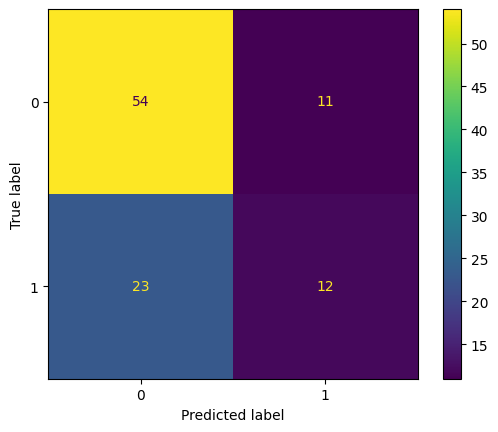

In [107]:
y_true = val_set["Risk_numerical"].values
print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**TODO 3.3** Train and evaluate another XGBClassifier, this time with input data restricted to the markov blanket found in TODO 2.4.

In [110]:
!pip install xgboost


In [117]:
## WRITE YOUR CODE BELOW
# Markov blanket variables from TODO 2.4
markov_blanket = ['Housing_numerical', 'Credit History', 'Saving accounts_numerical', 'Duration']

# Train XGBoost by using only the Markov blanket variables
xgb_clf_markov = xgb.XGBClassifier(enable_categorical=True)
xgb_clf_markov.fit(train_set[markov_blanket], train_set['Risk_numerical'])

# Predict on validation set
y_pred = xgb_clf_markov.predict(val_set[markov_blanket])

# Evaluate the performance
y_true = val_set["Risk_numerical"].values



Classification accuracy: 0.66


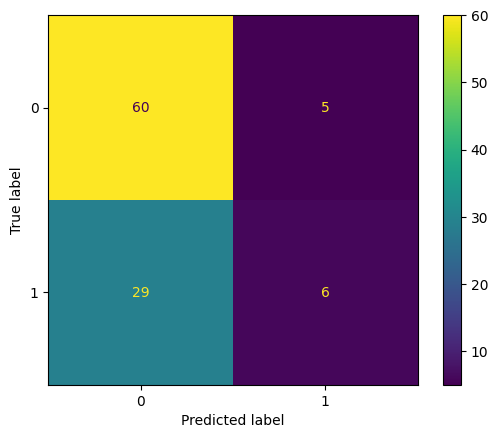

In [118]:
# Run the following

y_true = val_set["Risk_numerical"].values
print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**Question**: Conclude: did removing columns decrease the information on Risk contained by the dataset? Was this an expected behaviour?

**Question**: Did removing column increase accuracy? Suggest an explanation why.

**Question**: Conclude on the predictive performance of bayesian modeling versus XGBoost for this dataset.

Answer1: Yes, removing columns likely decreased the information on "Risk" as fewer variables were available for prediction. The slight drop in prediction accuracy was expected, as some useful information related to "Risk" was lost when columns outside the Markov Blanket were removed.
Answer2: No, removing columns did not increase accuracy. In fact, the accuracy stayed the same at 66%. This suggests that the Markov Blanket already contains most of the important information related to "Risk".
Answer3: Bayesian MAP query and XGBoost, performed similarly, with the Bayesian model slightly outperforming xgBoost. This shows that Bayesian modeling works just as well as XGBoost for this dataset, and both are solid choices for predicting credit risk here.
